In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import time
import corner



from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
#%matplotlib nbagg
%matplotlib inline

# Hello

We're going to fit a model to an emission line!


The model will be made up of two parts: the continuum, modelled as a straight line, and the line itself, modelled by a Gaussian.



so Naively, we're going to use a model with the following form. 


$$f(\lambda) = c + m\lambda + \frac{A}{\sqrt{2\pi \sigma^2}}\cdot \exp\left({ \frac{-(\lambda-\mu)^2}{\sigma^2} }\right) $$



We're using 5 parameters $(y0,y1,A,\mu,\sigma)$. We have replaced $m$ and $c$ because the data might not be anywhere near 0 (in fact, it almost definitely won't) and thus a small change in m will result in a very large change in c. This garuntees that $m$ is incredibly sensitive and $c$ is very insensitive, which is unhelpful. 

$y0$ and $y1$ therefore represent y values at the start and end points of the data. Translating these back into an m and c is fairly trivial:

$$m = \frac{(y1-y0)}{(x1-x0)}$$


$$c = \frac{1}{2} \left[ (y0+y1) - \frac{x1+x0}{x1-x0} (y1-y0) \right] $$

your first job as a warmup is to complete a model function here, so that we can plot some stuff!


In [17]:
def model(x,theta):
    
    x0,x1       = x[0],x[-1]
    y0,y1,A,M,S = theta
    
    m = (y1-y0)/(x1-x0)
    c = 0.5*(y0+y1 - (x1+x0)/(x1-x0)*(y1-y0)) 
    
    continuum = c + m*x

    gaussian  = A/(np.sqrt(2*np.pi*S**2))*np.exp(-(x-M)**2/(2*S**2))
    
    
    
    return continuum + gaussian

# The Truth

Lets do a quick realisation of our model we can compare to


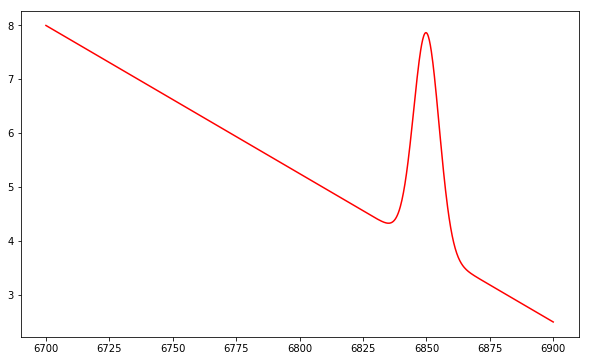

In [18]:
### This is going to be the truth of our fake emission line


y0_true = 8.0
y1_true = 2.5
A_true  = 50.
M_true  = 6850.0
S_true  = 5.0

theta_true = np.array( [y0_true,y1_true,A_true,M_true,S_true] )


x = np.linspace( 6700,6900,1000 )
y_true = model( x,theta_true )


plt.figure(1, figsize=(10,6) )
plt.plot( x, y_true, color='r' )

# Generating Fake Data

We're now going to add adjustable gaussian noise, by defining the signal to noise at the very top of the line.



<Container object of 3 artists>

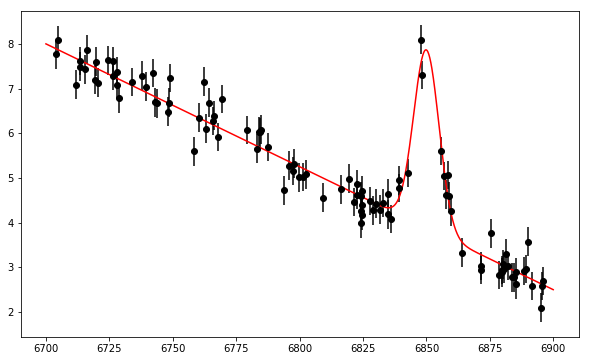

In [20]:
 

Nobs = 100
SN = 25.0  # y/y_err at the top of the gaussian


x_obs   = np.sort(np.random.rand(Nobs))  *(x[-1]-x[0]) + x[0]  # Nobs random x values, sorted in order of WL
y_obs   = model(x_obs,theta_true)   + np.random.normal( 0, np.max(y_true)/SN ,Nobs)  # run through model and add noise
y_err   = np.ones(len(y_obs)) * np.max(y_true)/SN   # array of errors, all the same for now.



plt.figure(2, figsize=(10,6) )
plt.plot( x, y_true, color='r' )
plt.errorbar(x_obs,y_obs ,y_err , marker='o',color='k',linestyle='none')



# Bayes' Theorem

Now for the good bit, we're going to recuild the emission line just from the data pretend we just made an observation, and so all we have are x_obs, y_obs and y_err.


We're going to exploit Bayes' Rule - 

$$ P(A|B) \propto P(B|A) P(A) $$

with the "events"

- A - This set of parameters is correct
- B - The observations

Bayes' Theorem is made up of 3 important parts:

- $P(A|B)$: the Posterior or the Probability. The probaability our parameters are correct given the observations.
- $P(B|A)$: the likelihoos. The probability of the observations coming from the model parameters we are considering.
- $P(A)$: the prior. This is the probability of a set of parameters being true *not* based on the data. For example we know a standard deviation should be $>0$.




In [21]:

## This block is just defining some numbers which effectively decide the depth that the MCMC goes in. 
## It is more art than science to get these numbers right, trading off speed with reliability.


params = ['y0','y1','A','M','S']
nwalkers = 30  # number of individual chains to make
ndim     = len(params) # number of dimensions
preburns = 200  # length of "burn-in" period to be discarded
burns    = 2000 # number of iterations to be used after initial burn-in.



# PRIOR

 The prior encodes information we already know. Other than our data we are going to pretend we don't know anything
 and therefore use an "uninformed" or "uniform" prior.
 
$$ P(x) = 
\begin{cases} 
      1 & xmin\leq x \leq xmax \\
      0 & otherwise
   \end{cases}
   $$
 In Practice I'm doing this as a dictionary with 2 entires in each key - the min/max of the extent of the uniform prior.
 
 
 
 
*your second job is to decide what sensible limits on the priors should be! 
Think about sensible physical limits based on the data you observe/the physical meaning of the parameter. Try not to refer to the answer above :)*

In [23]:


PRIORS = {     'y0'   :  [ 0   ,   20 ] ,
               'y1'   :  [ 0   ,   20 ] ,
               'A'    :  [  0   ,    100 ] ,
               'M'    :  [  6700   ,    7000 ] ,
               'S'    :  [  0   ,    10 ]  }





## we also are defining a function here which does the mathematical operation above for each parameter.

def lnprior(theta):

    P = np.zeros(len(theta))

    for i,p in enumerate(params):
        if ( PRIORS[p][0]< theta[i] < PRIORS[p][1] ): 
            P[i] = 1.0
        else:
            P[i] = 0.0
            
    # return the log of the probability, in this case either log of 1 or 0.
    if np.product(P) == 0.0: 
        return -np.inf
    else: 
        return 0.0

   

    
 We then define the other two functions we need. 

- A (log) likelihood function, which in our case will simply calculate the probability based on $\chi^2$.    
    
- A (log) posterior function. This calculates the posterior by taking the product of the 
     prior probability and the likelihood probability.



In [24]:

def lnlike(theta,x,y,dy):
    return -0.5*sum( ( y-model( x, theta  ) )**2 / dy**2)         



def lnprob(theta,x,y,dy):
    
    lp = lnprior(theta)
    ll = lnlike(theta,x,y,dy)

    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    else:
        return lp + ll






    
# You now have everything you need to run an MCMC


You could make your own, but we're going to be using "emcee".

emcee works by having many different points - called walkers - be iterated at once (you can actually parallellise this). These walkers "share" information between eachother to get a better result than a typical individual walker, but how this is done is beyond the scope here. All we need to do is pick their initial starting value for each parameter.

We need to start out by defining where the walkers are going to start.



In [25]:

pos = np.zeros((nwalkers,ndim))  

for j,p in enumerate(params):
    # I'm choosing to uniformally but randomly distribute them within the prior range.
    # you might choose something more systematic but I find for good prior choices this works well.
    pos[:,j] = np.random.rand(nwalkers)*(PRIORS[params[j]][1]-PRIORS[params[j]][0]) + PRIORS[params[j]][0]


    
    
    

# EnsembleSampler is the main object emcee uses to carry out analysis. 
# the args command is a list of any extra things you wish to pass to lnprob, in our case 
# we did " def lnprob(theta,x,y,dy) " - so we need to pass lnprob our x,y and y errors in addition to our parameters.

sampler = emcee.EnsembleSampler( nwalkers, ndim, lnprob, args=[x_obs,y_obs,y_err] )



time0 = time.time()
print('MCMC start ')

pos, prob, state = sampler.run_mcmc(pos, burns+preburns )

time1=time.time()
print('MCMC end, Time taken: ',time1-time0)
samples = sampler.chain[:, preburns:, :].reshape(-1, ndim)






MCMC start 
MCMC end, Time taken:  4.233342885971069




# OUTPUTS

We are going to produce three types of useful output plots.

- "Chain plot" This is a group of plots of where each walker is in parameter space as a function of iteration number. For a successful MCMC we should see a tangled mess, with most walkers then moving towards the best fit value as time goes on.

- "Corner plot" Along the diagonal is the 1d proability distributions, off diagonal elements are the 2d probability distributions between those two parameters. Any other parameter in each plot is integrated over (i.e. we are assuming that those parameters are held fixed at the "right" value)

- "Model plot" Finally, we're going to rebuild our model witht he best fit parameters and see how that compares to the original "truth" we constructed right at the start!

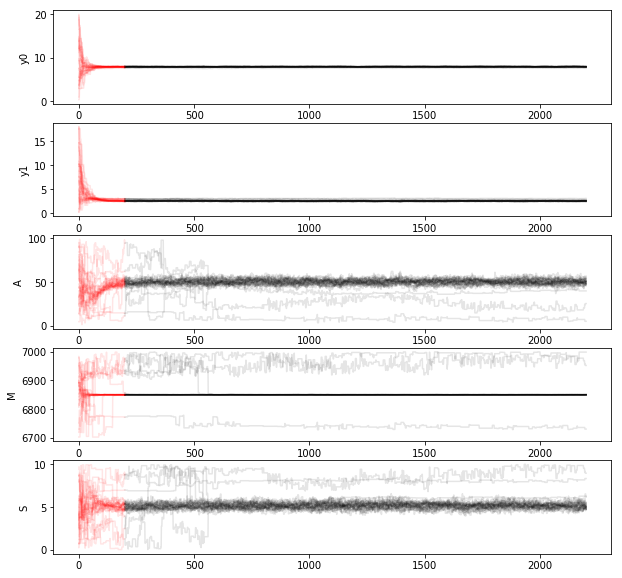

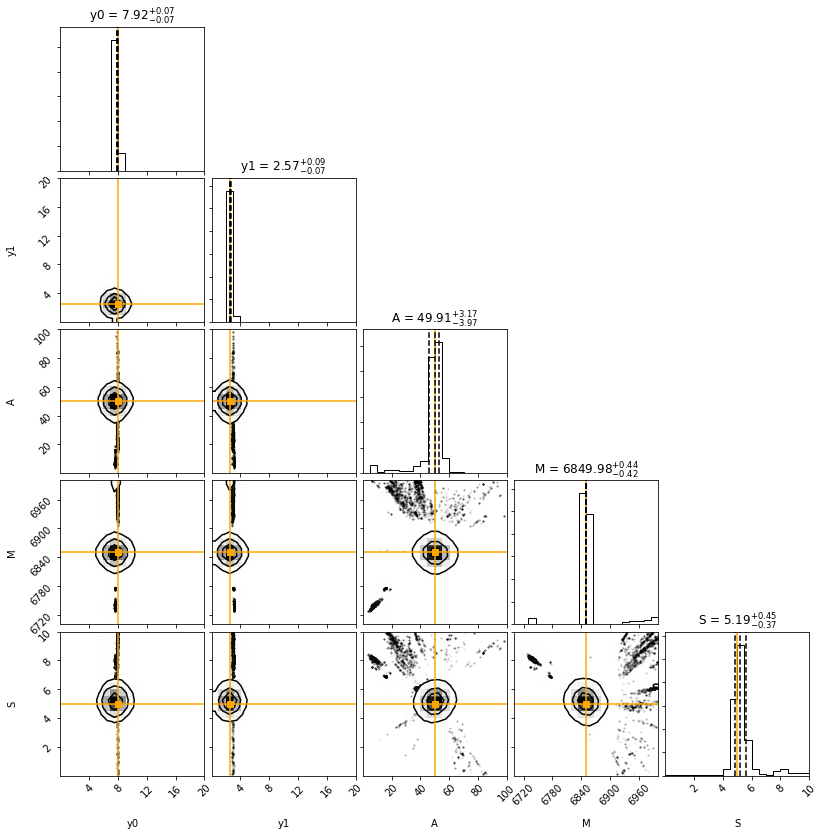

In [26]:


fig2,axarr = plt.subplots( ndim,1 ,figsize=(10,10))

for j in range(ndim):
    for i in range(nwalkers):
        axarr[j].plot( np.arange(0, preburns ,1) , sampler.chain[i,:preburns,j] , alpha=0.1, color='r' )
        axarr[j].plot( np.arange(preburns, burns+preburns ,1) , sampler.chain[i,preburns:,j] , alpha=0.1, color='k' )

    axarr[j].set_ylabel( params[j] )

    
    
    
#### CORNER PLOT
# Another useful plot. This can allow you to see degeneracies between your variables, and also to see 
# the 1 and 2d probability distributions of each parameter.
# if you don't have corner, feel free to comment this out and make hisograms of each parameter with 
# plt.hist( samples[:,i] ) where i runs from 0 to ndim
import corner
fig = corner.corner(samples, labels= params , truths = theta_true, truth_color='orange', show_titles=True,\
        quantiles=[.16,.50,.84], smooth=1.0, \
        range = [(PRIORS[i][0],PRIORS[i][1]) for i in params])






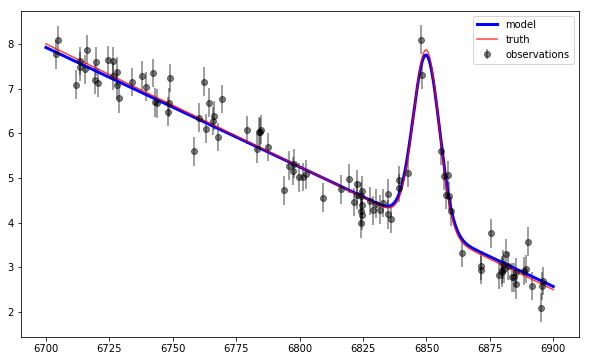

In [27]:

# finally if you are applying a fit, generally you take the median of the burned in chain for each parameter, and treat that as your best fit.
# similarly the 1 sigma errors would be the 16th and 84th percentiles of these chains.

median_params =   [np.percentile(samples[:,i],50) for i in range(ndim)]
 





plt.figure(figsize=(10,6))

# plot best fit, truth, and observations
plt.errorbar(x_obs,y_obs,y_err,color='k',marker='o',linestyle='none',label='observations',alpha=0.5)


plt.plot(x, model(x,median_params ) ,color='b',label='model',linewidth=3.0)
plt.plot(x, model(x,theta_true) , color='r',alpha=0.75 ,label='truth')

plt.legend()



In [ ]:
PRIORS = {     'y0'   :  [ 0 , y_obs.max()*2 ] ,
               'y1'   :  [ 0 , y_obs.max()*2 ] ,
               'A'    :  [ 0,  np.trapz(abs(y_obs),x_obs)*2 ],
               'M'   :  [ x.min() , x.max() ] ,
               'S'    :  [ 0  ,  x.max()-x.min()  ] }

